# **Milestone 2**

We have built two Convolutional Neural Network architectures in Milestone 1. Here, we will further try to achieve better performance by increasing the number of parameters/weights. Therefore, we will start this Milestone with three popular Transfer Learning architectures, namely, VGG16, ResNet v2, and Efficient Net. Please feel free to explore other pre-trained models as well. Link to Keras documentation for pre-trained models - https://keras.io/api/applications/

**Note:** We will mount our drive and import our dataset once again for Milestone 2.

## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is not a library that can be downloaded locally on your device.**

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [2]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

### **Let us load the data**

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [3]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. Unlike in Milestone 1, we will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [5]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)
validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**

* In this model, we will import till the **'block5_pool'** layer of the VGG16 model. You can scroll down in the model summary and look for 'block5_pool'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'block5_pool' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [7]:
from sklearn.preprocessing import normalize
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable = False

# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation='relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(rate=0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model

### **Compiling and Training the VGG16 Model**

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [9]:
# Write your code to compile the vggmodel. Use categorical crossentropy as the loss function, Adam Optimizer with 0.001 learning rate, and set metrics to 'accuracy'.
vggmodel.compile(optimizer=Adam(learning_rate=0.001), loss='CategoricalCrossentropy', metrics=['accuracy'])

In [10]:
history_vggmodel = vggmodel.fit(train_set, validation_data=validation_set, epochs=epochs)
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train the model for 20 epochs.

Epoch 1/20
473/473 [==============================] - 33s 52ms/step - loss: 1.2509 - accuracy: 0.4135 - val_loss: 1.2819 - val_accuracy: 0.3739
Epoch 2/20
473/473 [==============================] - 24s 51ms/step - loss: 1.1905 - accuracy: 0.4565 - val_loss: 1.3018 - val_accuracy: 0.3787
Epoch 3/20
473/473 [==============================] - 24s 50ms/step - loss: 1.1578 - accuracy: 0.4790 - val_loss: 1.2449 - val_accuracy: 0.4169
Epoch 4/20
473/473 [==============================] - 24s 51ms/step - loss: 1.1480 - accuracy: 0.4835 - val_loss: 1.2454 - val_accuracy: 0.3910
Epoch 5/20
473/473 [==============================] - 24s 51ms/step - loss: 1.1359 - accuracy: 0.4908 - val_loss: 1.2549 - val_accuracy: 0.4083
Epoch 6/20
473/473 [==============================] - 24s 51ms/step - loss: 1.1258 - accuracy: 0.5026 - val_loss: 1.2431 - val_accuracy: 0.4018
Epoch 7/20
473/473 [==============================] - 24s 50ms/step - loss: 1.1169 - accuracy: 0.5013 - val_loss: 1.3057 - val_accuracy:

### **Evaluating the VGG16 model**

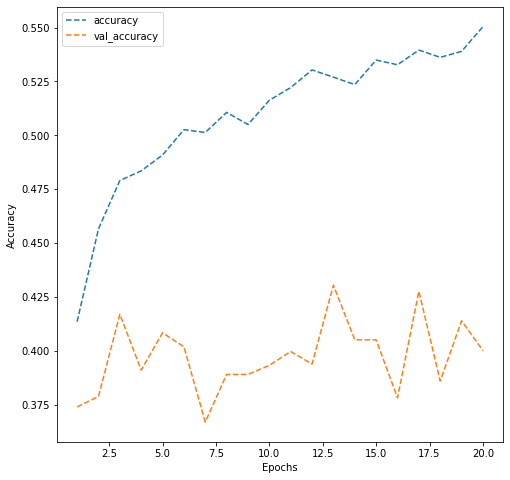

In [11]:
# Write your code to evaluate model performance on the test set
dict_hist = history_vggmodel.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

**Think About It:**

- What do you infer from the general trend in the training performance? 
- Is the training accuracy consistently improving? 
- Is the validation accuracy also improving similarly?

**Observations and Insights: The general trend in the training performance is that it went slightly up for the accuracy, but not for the val_accuracy as we know, the val_accuracy is a more accurate value of precission and therefore the performance of this model on the test set wasn't great..**

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [12]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                       

### **Model Building**

* In this model, we will import till the **'conv5_block3_add'** layer of the ResNet model. You can scroll down in the model summary and look for 'conv5_block3_add'. You can choose any other layer as well.
* Then we will add a Flatten layer, which receives the output of the 'conv5_block3_add' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* You may use Dropout and BatchNormalization layers as well.
* Then we will add our last dense layer, which must have 4 neurons and a 'softmax' activation function.

In [13]:
transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')
Resnet.trainable=False

# Add classification layers on top of it
x = Dense(512, activation = 'relu')(x)
# Flattenning the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer_Resnet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(rate=0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(transfer_layer_Resnet.input, pred) # Initializing the model

### **Compiling and Training the Model**

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )  # Write your code here. You may play around with the hyperparameters if you wish.


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001) # Write your code here. You may play around with the hyperparameters if you wish.


callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [15]:
vggmodel.compile(optimizer=Adam(learning_rate=0.001), loss='CategoricalCrossentropy', metrics=['accuracy'])

In [16]:
history_vggmodel = vggmodel.fit(train_set, validation_data=validation_set, epochs=epochs)
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.


Epoch 1/20
473/473 [==============================] - 25s 51ms/step - loss: 1.0244 - accuracy: 0.5494 - val_loss: 1.2700 - val_accuracy: 0.4129
Epoch 2/20
473/473 [==============================] - 24s 51ms/step - loss: 1.0140 - accuracy: 0.5571 - val_loss: 1.2953 - val_accuracy: 0.4169
Epoch 3/20
473/473 [==============================] - 24s 51ms/step - loss: 1.0165 - accuracy: 0.5555 - val_loss: 1.3107 - val_accuracy: 0.4010
Epoch 4/20
473/473 [==============================] - 24s 51ms/step - loss: 1.0147 - accuracy: 0.5521 - val_loss: 1.2793 - val_accuracy: 0.4059
Epoch 5/20
473/473 [==============================] - 24s 51ms/step - loss: 1.0089 - accuracy: 0.5619 - val_loss: 1.2946 - val_accuracy: 0.3914
Epoch 6/20
473/473 [==============================] - 24s 51ms/step - loss: 1.0006 - accuracy: 0.5633 - val_loss: 1.2916 - val_accuracy: 0.4240
Epoch 7/20
473/473 [==============================] - 24s 51ms/step - loss: 0.9962 - accuracy: 0.5656 - val_loss: 1.2946 - val_accuracy:

### **Evaluating the ResNet Model**

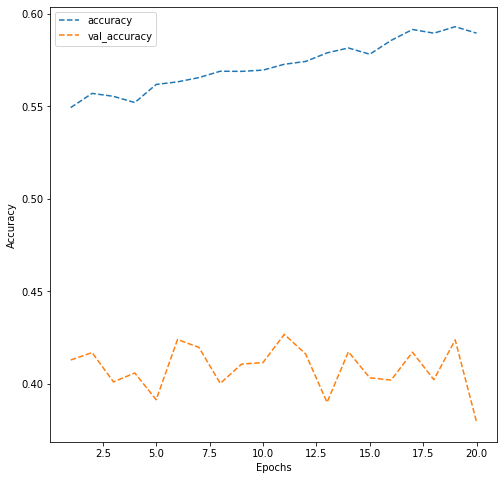

In [17]:
# Write your code to evaluate model performance on the test set
dict_hist = history_vggmodel.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

**Observations and Insights:The general trend in the training performance is that it went slightly up for the accuracy, but not for the val_accuracy as we know, the val_accuracy is a more accurate value of precission and therefore the performance of this model on the test set wasn't great..**

**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

In [18]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

35839040/35839040 [==============================] - 0s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_5[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model Building**

**Build your own Architecture on top of the transfer layer. Be sure to have a Flatten layer after your transfer layer and also make sure you have 4 neurons and softmax activation function in your last dense layer**

In [19]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
EfficientNet.trainable = False

# Add your Flatten layer.
x = Flatten()(transfer_layer_EfficientNet.output)
# Add your Dense layers and/or BatchNormalization and Dropout layers
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(64, activation = 'relu')(x)
BatchNormalization()(x)

# Add your final Dense layer with 4 neurons and softmax activation function.
pred = Dense(4, activation = 'softmax')(x)

Efficientnetmodel = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )  # Write your code here. You may play around with the hyperparameters if you wish.

reduce_learningrate = reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)  # Write your code here. You may play around with the hyperparameters if you wish.

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 20

In [21]:
vggmodel.compile(optimizer=Adam(learning_rate=0.001), loss='CategoricalCrossentropy', metrics=['accuracy'])

In [22]:
history_vggmodel = vggmodel.fit(train_set, validation_data=validation_set, epochs=epochs)
# Write your code to fit your model. Use train_set as your training data and validation_set as your validation data. Train your model for 20 epochs.


Epoch 1/20
473/473 [==============================] - 25s 51ms/step - loss: 0.9326 - accuracy: 0.5949 - val_loss: 1.3074 - val_accuracy: 0.4195
Epoch 2/20
473/473 [==============================] - 24s 51ms/step - loss: 0.9276 - accuracy: 0.6015 - val_loss: 1.4041 - val_accuracy: 0.4145
Epoch 3/20
473/473 [==============================] - 24s 51ms/step - loss: 0.9300 - accuracy: 0.5945 - val_loss: 1.3511 - val_accuracy: 0.4262
Epoch 4/20
473/473 [==============================] - 24s 50ms/step - loss: 0.9249 - accuracy: 0.5937 - val_loss: 1.3767 - val_accuracy: 0.3944
Epoch 5/20
473/473 [==============================] - 24s 51ms/step - loss: 0.9241 - accuracy: 0.6018 - val_loss: 1.3388 - val_accuracy: 0.4322
Epoch 6/20
473/473 [==============================] - 24s 51ms/step - loss: 0.9158 - accuracy: 0.6024 - val_loss: 1.4007 - val_accuracy: 0.4004
Epoch 7/20
473/473 [==============================] - 24s 50ms/step - loss: 0.9170 - accuracy: 0.6069 - val_loss: 1.3425 - val_accuracy:

### **Evaluating the EfficientnetNet Model**

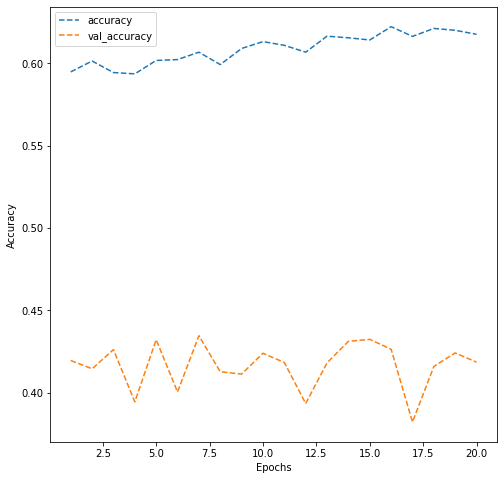

In [23]:
dict_hist = history_vggmodel.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

**Observations and Insights: Even if the accuracy hasn't increased by much we can see a steady decrease in the loss function which is positive because it means we're loosing less data**

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [24]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 3.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,3.),
                                    rescale=1./255,
                                    shear_range=0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,3.),
                                    rescale=1./255,
                                    shear_range=0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

* In this network, we plan to have 5 Convolutional Blocks
* Add first Conv2D layer with **64 filters** and a **kernel size of 2**. Use the 'same' padding and provide the **input shape = (48, 48, 1)**. Use **'relu' activation**.
* Add your BatchNormalization layer followed by a LeakyRelU layer with Leaky ReLU parameter of **0.1**
* Add MaxPooling2D layer with **pool size = 2**.
* Add a Dropout layer with a Dropout Ratio of **0.2**. This completes the first Convolutional block.
* Add a second Conv2D layer with **128 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.**
* Follow this up with a similar BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer like above to complete your second Convolutional Block.
* Add a third Conv2D layer with **512 filters** and a **kernel size of 2**. Use the **'same' padding** and **'relu' activation.** Once again, follow it up with a BatchNormalization, LeakyRelU, Maxpooling2D, and Dropout layer to complete your third Convolutional block.
* Add a fourth block, with the Conv2D layer having **512 filters**.
* Add the fifth block, having **128 filters**.
* Then add your Flatten layer, followed by your Dense layers.
* Add your first Dense layer with **256 neurons** followed by a BatchNormalization layer, a **'relu'** Activation, and a Dropout layer. This forms your first Fully Connected block
* Add your second Dense layer with **512 neurons**, again followed by a BatchNormalization layer, **relu** activation, and a Dropout layer.
* Add your final Dense layer with 4 neurons.
* Compile your model with the optimizer of your choice.

In [25]:
no_of_classes = 4

model3 = Sequential()

# Add 1st CNN Block
model3.add(Conv2D(64, kernel_size=2, input_shape=(48, 48, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size=2))
# Add 2nd CNN Block
model3.add(Conv2D(128, kernel_size=2, activation='relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size=2))# Add 3rd CNN Block
model3.add(Conv2D(512, kernel_size=2, activation='relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size=2))
# Add 4th CNN Block
model3.add(Conv2D(512, kernel_size=2))
# Add 5th CNN Block
model3.add(Conv2D(128, kernel_size=2))

model3.add(Flatten())

# First fully connected layer
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
# Second fully connected layer
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(4, activation = 'softmax'))

### **Compiling and Training the Model**

In [26]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

epochs = 35

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001 , model = 'auto')

callbacks = [checkpoint, reduce_lr]

In [29]:
# Write your code to compile your model3. Use categorical crossentropy as the loss function, Adam Optimizer with 0.003 learning rate, and set metrics to 'accuracy'.
early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 45


     

# Write your code to compile your model1. Use categorical crossentropy as your loss function, Adam Optimizer with 0.001 learning rate, and set your metrics to 'accuracy'. 
model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')

In [30]:
history = model3.fit(train_set, validation_data=validation_set, epochs=epochs, batch_size=32)
# Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train your model for 35 epochs.

Epoch 1/45
473/473 [==============================] - 26s 52ms/step - loss: 1.4081 - accuracy: 0.3739 - val_loss: 1.6297 - val_accuracy: 0.2962
Epoch 2/45
473/473 [==============================] - 24s 51ms/step - loss: 1.2501 - accuracy: 0.4381 - val_loss: 1.6419 - val_accuracy: 0.3279
Epoch 3/45
473/473 [==============================] - 24s 51ms/step - loss: 1.1711 - accuracy: 0.4781 - val_loss: 1.3288 - val_accuracy: 0.3791
Epoch 4/45
473/473 [==============================] - 24s 51ms/step - loss: 1.1425 - accuracy: 0.4894 - val_loss: 1.2239 - val_accuracy: 0.4117
Epoch 5/45
473/473 [==============================] - 24s 51ms/step - loss: 1.0927 - accuracy: 0.5136 - val_loss: 1.3497 - val_accuracy: 0.3799
Epoch 6/45
473/473 [==============================] - 24s 51ms/step - loss: 1.0791 - accuracy: 0.5215 - val_loss: 1.2640 - val_accuracy: 0.4374
Epoch 7/45
473/473 [==============================] - 24s 51ms/step - loss: 1.1492 - accuracy: 0.4891 - val_loss: 1.2768 - val_accuracy:

### **Evaluating the Model on Test Set**

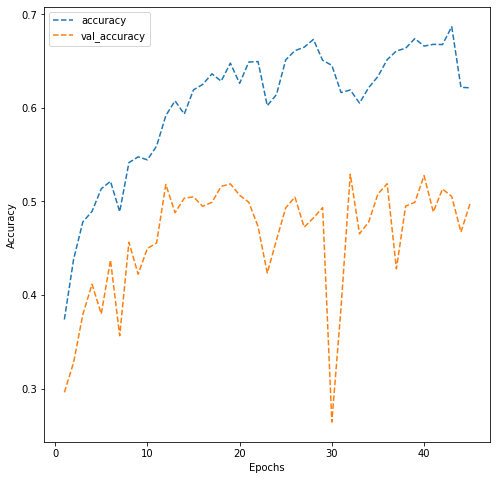

In [31]:
dict_hist = history.history

list_ep = [i for i in range(1, 46)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

**Observations and Insights:As we can see through the convolutional mehtod the score is far greater than with the vgg models we can see a great increase also because of the increase epochs.**

### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 4ms/step


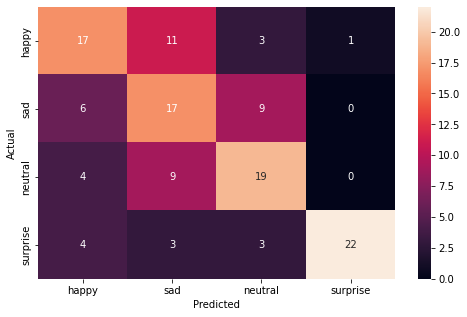

In [32]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'rgb',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
test_images, test_labels = next(test_set)

# Write the name of your chosen model in the blank
pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report


# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:In my opinion the convoluted neural network is the most accurate of the models because it is the most layered one and the most reliable one also based on accuracy**

## **Conclusion:The convoluted neural network had the best performance**

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?